In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Data

In [51]:
users = ["A", "B", "C"]  # the three users we are interested in
states = {"work": 0, "pause": 1, "game": 2, "browse": 3, "stream": 4}   # their states (activities)
observations = ["very_low", "low", "medium", "high", "very high"]   # our observations (LED blinking frequency)

def convert_state(state):
    return states[state]


def load_activities(users):
    activities_data = {}   # map user -> activties_data
    for u in users:
        # load activities CSV
        path = os.path.join("data", u + "_activities.csv")
        data = np.genfromtxt(path, dtype='unicode', delimiter='|')
        # we are only interested in the second column
        # and map the activity names to indices
        activities_data[u] = [list(map(convert_state, d.split())) for d in data[:, 1]]
    return activities_data


def plot_model(model, title=None):
    if (len(model) == 2):
        A, I = model
        plt.figure()
        plt.matshow(A)
        if title:
            plt.title("Transition matrix " + title)
        #plt.tight_layout()
        plt.show()
        
        
activities_data = load_activities(users)

# Task 1: Markov Chain model

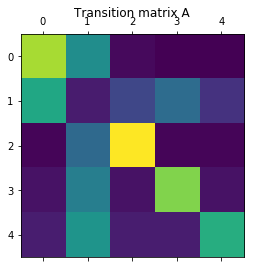

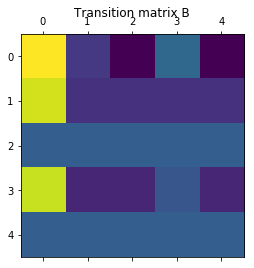

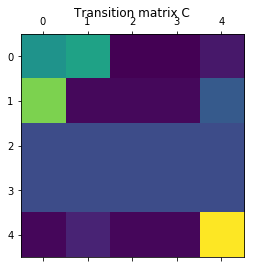

In [82]:
def init_chain_model(states):
    """ Initialize an empy Markov chain model """
    # transition probability matrix
    A = np.zeros((len(states), len(states)))
    
    # initial state probability vector
    I = np.zeros((1, len(states)))
    
    return (A, I)


def train_chain_model(model, activities_data):
    """ Trains a Markov chain model given """
    # get transition matrix and initial transition vector from model tuple
    A, I = model
    
    # get a counts matrix of same size as A
    # we use "ones_like" instead of "zeroes_like" so that
    # when normalizing we don't get divisions by zero
    # at the same time achieves Laplace smoothing
    # https://en.wikipedia.org/wiki/Additive_smoothing
    A_counts = np.ones_like(A)
    
    # loop sequences (daily activities)
    for seq in activities_data:
        # loop activities per day
        for idx in range(1, len(seq)):
            
            # TASK TODO: get current and last activity
            # and increase the according entry in the 
            # transition count matrix
            curr = seq[idx]
            last = seq[idx-1]
            A_counts[last, curr] += 1
            
    # normalize matrix rows to get probabilites
    # (so that the sum of each row is 1.0)
    # sum up rows, and then divide using broadcasting
    # https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html
    A = A_counts / A_counts.sum(axis=1, keepdims=True)
    return (A, I)


def inference_chain_model(model, sequence):
    A, I = model
    
    return 0.5


# train our models
for user in activities_data:
    user_activities_data = activities_data[user]
    chain_model = init_chain_model(states)
    chain_model = train_chain_model(chain_model, user_activities_data)
    plot_model(chain_model, title=user)
    
    #print(user)
    #print (chain_model[0])

# test data

# Hidden Markov Model functions


# Main logic